In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from tabulate import _table_formats, tabulate

from sklearn.neural_network import MLPRegressor
from sklearn import model_selection

In [2]:
datas = '/Users/pkrok/OneDrive/Python/Giannakopoulos/MyData.xlsx'

In [3]:
pd.set_option("display.max_columns", None)
df=pd.read_excel(datas)
df.head(2)
df['logD'] = np.log10(df['diffusivity'])
#df = df.dropna()

# Keep only the columns I need

In [4]:
df=df[[ 'aperture', 'size - van der Waals (Å)','logD']]
df.head()
df = df.dropna()
df

,aperture,size - van der Waals (Å),logD
0,3.92,2.66,-7.221849
1,3.92,3.13,-8.769551
5,3.92,3.25,-8.585027
6,3.92,3.59,-9.236572
7,3.92,3.72,-9.197226
...,...,...,...
842,2.95,3.13,-7.455932
843,2.95,2.94,-9.180456
844,2.95,3.24,-9.096910
845,2.95,3.13,-9.638272


# Bring my data into shape

In [5]:
df=df.rename(columns={'size - van der Waals (Å)':'diameter' })

In [6]:
df=df.reset_index(drop=True)
df.head()

,aperture,diameter,logD
0,3.92,2.66,-7.221849
1,3.92,3.13,-8.769551
2,3.92,3.25,-8.585027
3,3.92,3.59,-9.236572
4,3.92,3.72,-9.197226


## K-fold Cross-Validation

In [7]:
from sklearn.model_selection import KFold

## Linear Regressor with K-fold Cross-Validation

In [8]:
from sklearn.tree import DecisionTreeRegressor
tree=DecisionTreeRegressor(random_state=0)
from sklearn import metrics

In [9]:
dfMetrics = pd.DataFrame(columns = ['data', 'testPerf', 'trainPerf', 'testMSE', 'trainMSE', 'testMaxEr', 'trainMaxEr', 'testMedABSErr', 'trainMedABSErr'])

NNregr = MLPRegressor(hidden_layer_sizes=(25, 20, 15, 10, 5), solver='adam', random_state=1, max_iter=2000)

kfold = KFold(n_splits=40, shuffle=True, random_state = None)

#make the test set
testdf=df.iloc[346:, 0:]
testx = np.asanyarray(testdf[['aperture', 'diameter']])
testy = np.asanyarray(testdf[['logD']])   

i=0

for i in range(50, 545, 5):
    data_y1 = list()
    data_y2 = list()
    data_predTrain = list()
    data_predTest = list()
    dataTrueTest = list()
    
    df2=df.iloc[:i, :]
    x = np.asanyarray(df2[['aperture', 'diameter']])
    y = np.asanyarray(df2[['logD']])

    # enumerate splits
    for train_ix, test_ix in kfold.split(x):
        # get data
        train_X, test_X = x[train_ix], x[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        
        # fit model
        NNregr.fit(train_X, train_y.ravel())
       
        # make predictions
        pred_train = NNregr.predict(train_X)
        pred_test = NNregr.predict(testx)
        
        #store
        data_y2.extend(train_y)
        data_predTrain.extend(pred_train)
        data_predTest.extend(pred_test)
        dataTrueTest.extend(testy)
        
    # evaluate
    R2_test = (metrics.r2_score(dataTrueTest,data_predTest))
    R2_train = (metrics.r2_score(data_y2,data_predTrain))
    MSE_test = (metrics.mean_squared_error(dataTrueTest,data_predTest))
    MSE_train = (metrics.mean_squared_error(data_y2,data_predTrain))
    MaxEr_test = metrics.max_error(dataTrueTest,data_predTest)
    MaxEr_train = metrics.max_error(data_y2,data_predTrain)
    MedABSErr_test = metrics.median_absolute_error(dataTrueTest,data_predTest)
    MedABSErr_train = metrics.median_absolute_error(data_y2,data_predTrain)
    
    dfMetrics.loc[i, 'testPerf'] = R2_test
    dfMetrics.loc[i, 'trainPerf'] = R2_train
    dfMetrics.loc[i, 'testMSE'] = MSE_test
    dfMetrics.loc[i, 'trainMSE'] = MSE_train
    dfMetrics.loc[i, 'testMaxEr'] = MaxEr_test
    dfMetrics.loc[i, 'trainMaxEr'] = MaxEr_train
    dfMetrics.loc[i, 'testMedABSErr'] = MedABSErr_test
    dfMetrics.loc[i, 'trainMedABSErr'] = MedABSErr_train
    dfMetrics.loc[i, 'data'] = i

In [10]:
len(dataTrueTest)

320

In [11]:
len(data_predTest)

320

In [12]:
# dfMetrics.tail(20)
# data_y2

<function matplotlib.pyplot.show(close=None, block=None)>

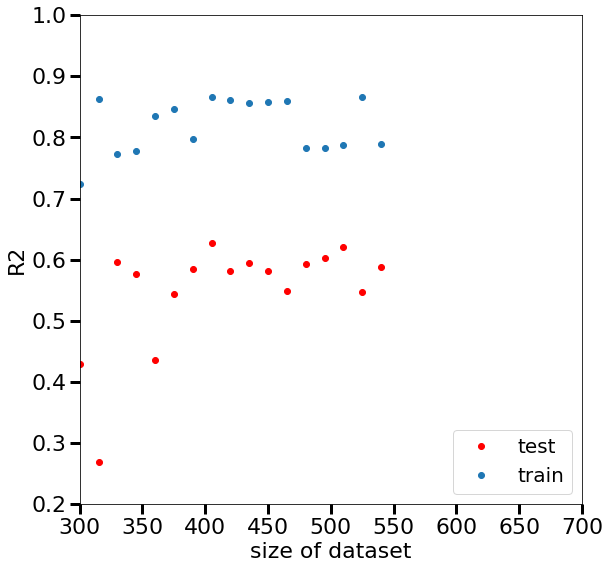

In [20]:
AxX=dfMetrics['data']
AxY=dfMetrics['testPerf']
AxY2=dfMetrics['trainPerf']
plt.plot(AxX, AxY, 'ro', label='test')
plt.plot(AxX, AxY2, 'o', label='train')

plt.ylim(0.2, 1)
plt.xlim(300, 700)
#plt.xscale('log')
plt.xlabel('size of dataset', fontsize=22)
plt.ylabel('R2',fontsize=22)
plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (9,9)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)
plt.legend(loc='lower right', fontsize=20)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

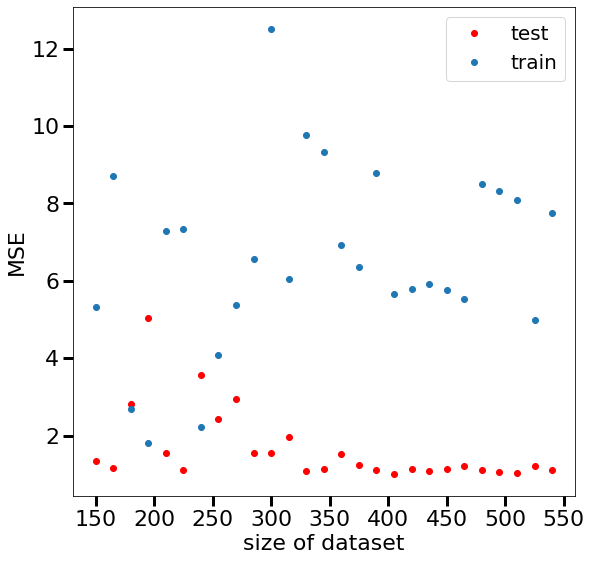

In [21]:
AxX=dfMetrics['data']
AxY=dfMetrics['testMSE']
AxY2=dfMetrics['trainMSE']
plt.plot(AxX, AxY, 'ro', label='test')
plt.plot(AxX, AxY2, 'o', label='train')

#plt.ylim(0, 0.5)
#plt.xlim(0, 600)
#plt.xscale('log')
plt.xlabel('size of dataset', fontsize=22)
plt.ylabel('MSE',fontsize=22)
plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (9,9)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)
plt.legend(loc='upper right', fontsize=20)

plt.show

# Without K-fold

In [28]:
dfMetrics = pd.DataFrame(columns = ['data', 'testPerf', 'trainPerf', 'testMSE', 'trainMSE', 'testMaxEr', 'trainMaxEr', 'testMedABSErr', 'trainMedABSErr'])

NNregr = MLPRegressor(hidden_layer_sizes=(35, 30, 15, 10, 5), solver='lbfgs', random_state=1, max_iter=3000)

#make the test set
testdf=df.iloc[346:, 0:]
testx = np.asanyarray(testdf[['aperture', 'diameter']])
testy = np.asanyarray(testdf[['logD']])   

i=0

for i in range(150, 345, 5):
    data_y1 = list()
    data_y2 = list()
    data_predTrain = list()
    data_predTest = list()
    dataTrueTest = list()
    
    df2=df.iloc[:i, :]
    x = np.asanyarray(df2[['aperture', 'diameter']])
    y = np.asanyarray(df2[['logD']])
    
    NNregr.fit(x,y.ravel())
    pred_train = NNregr.predict(x)
    pred_test = NNregr.predict(testx)
        
    # evaluate
    R2_test = (metrics.r2_score(testy,pred_test))
    R2_train = (metrics.r2_score(y,pred_train))
    MSE_test = (metrics.mean_squared_error(testy,pred_test))
    MSE_train = (metrics.mean_squared_error(y,pred_train))
    MaxEr_test = metrics.max_error(testy,pred_test)
    MaxEr_train = metrics.max_error(y,pred_train)
    MedABSErr_test = metrics.median_absolute_error(testy,pred_test)
    MedABSErr_train = metrics.median_absolute_error(y,pred_train)
    
    dfMetrics.loc[i, 'testPerf'] = R2_test
    dfMetrics.loc[i, 'trainPerf'] = R2_train
    dfMetrics.loc[i, 'testMSE'] = MSE_test
    dfMetrics.loc[i, 'trainMSE'] = MSE_train
    dfMetrics.loc[i, 'testMaxEr'] = MaxEr_test
    dfMetrics.loc[i, 'trainMaxEr'] = MaxEr_train
    dfMetrics.loc[i, 'testMedABSErr'] = MedABSErr_test
    dfMetrics.loc[i, 'trainMedABSErr'] = MedABSErr_train
    dfMetrics.loc[i, 'data'] = i

In [29]:
len(testy)

208

In [30]:
len(pred_test)

208

<function matplotlib.pyplot.show(close=None, block=None)>

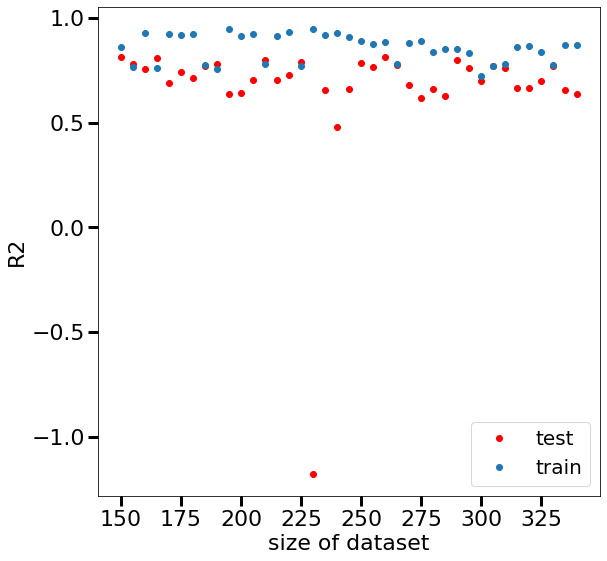

In [36]:
AxX=dfMetrics['data']
AxY=dfMetrics['testPerf']
AxY2=dfMetrics['trainPerf']
plt.plot(AxX, AxY, 'ro', label='test')
plt.plot(AxX, AxY2, 'o', label='train')

# plt.ylim(0.2, 1)
# plt.xlim(100, 700)
#plt.xscale('log')
plt.xlabel('size of dataset', fontsize=22)
plt.ylabel('R2',fontsize=22)
plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (9,9)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)
plt.legend(loc='lower right', fontsize=20)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

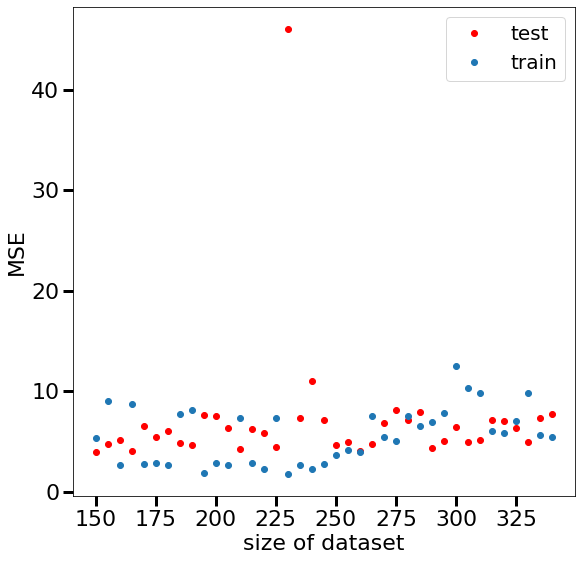

In [35]:
AxX=dfMetrics['data']
AxY=dfMetrics['testMSE']
AxY2=dfMetrics['trainMSE']
plt.plot(AxX, AxY, 'ro', label='test')
plt.plot(AxX, AxY2, 'o', label='train')

# plt.ylim(0, 11)
# plt.xlim(250, 600)
#plt.xscale('log')
plt.xlabel('size of dataset', fontsize=22)
plt.ylabel('MSE',fontsize=22)
plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (9,9)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)
plt.legend(loc='upper right', fontsize=20)

plt.show